# Deep Convolutional Generative Adversarial Network
## 深层卷积生成对抗网络
Tensorflow 实现版

论文地址：[https://arxiv.org/abs/1511.06434](https://arxiv.org/abs/1511.06434), Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks, 作者：Alec Radford & Luke Metz, Soumith Chintala [2016]

代码参考：[https://github.com/carpedm20/DCGAN-tensorflow](https://github.com/carpedm20/DCGAN-tensorflow), DCGAN in Tensorflow, 开源协议：MIT

## 1. 必要的import
需要用到的依赖包: `numpy`, `IPython`, `tensorflow`, `tqdm`, `matplotlib`, `skimage`

In [1]:
#removed keras, applying low-level api using tensorflow only
import os
import numpy as np
import tensorflow as tf
from IPython import display
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import random
from skimage import io
import math

d:\program files\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


**模型训练的全局设定**

In [2]:
#定义训练集的图片宽高度
image_width = 100
image_height = 100
#定义生成模型的噪音维度，原论文为100
noise_dim = 100
#定义生成模型最后一层(转置)卷积层的filter数，原论文为128
g_filter = 64
#定义判别模型第一层卷积层的filter数，原论文为128
d_filter = 64
#定义每次训练的batch数量，原论文128，内存/显存不够(OOM的时候)可以在2的指数倍向下取值
batch_size = 64
#定义训练集的路径
training_set_path = 'train'
#定义颜色通道数（在读取训练集时会自动修改）
channel_count = 3
#定义优化器的学习率和动量下降的beta1（论文为0.0002和0.5）
adam_lr = 0.0002
adam_beta1 = 0.5
#定义每次对生成器采样时的随机采样数量，显示当前训练的生成效果
random_count = 10
#定义每次对生成器采样时的样品数量，显示到tensorboard的训练历史上
sample_count = 2

#定义训练的epoch数
train_epoches = 10

## 2.(可选) 生成你的动漫人物头像训练集
代码参考：[https://github.com/nagadomi/lbpcascade_animeface](https://github.com/nagadomi/lbpcascade_animeface)

如果你已经有了自己一堆二次元萌妹，那么可以运行下面的代码生成训练集
```python
from build_training_set_v2 import build_training_set_v2
path_in = '存放二次元萌妹的图片文件夹路径'
path_out = 'train' #用于保存训练集的文件夹路径，建议与上面的 training_set_path 一致
dest_res = 100 #缩放的像素，建议与上面的 image_width, image_height 一致

#运行下面代码即可生成训练集
build_trainnig_set_v2(path_in, path_out, dest_res)
```
如果需要，在这下方插入单元格运行该代码即可

In [3]:
#加载训练集
def load_training_set():
    files = os.listdir(training_set_path)
    list_images = []
    for file in files:
        abs_path = os.path.join(training_set_path, file)
        if os.path.isfile(abs_path):
            image = io.imread(abs_path)
            list_images.append(image)
    ret_tensor = np.array(list_images)
    #rescale data
    ret_tensor = (ret_tensor - 127.5) / 127.5
    if ret_tensor.shape[1] != image_height or ret_tensor.shape[2] != image_width:
        raise ValueError('训练集的图片宽高与设定不同，请修改设定大小')
    return ret_tensor.astype('float32')
#设置显存增长，避免占用全部显存
def set_vram_growth():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config = config)
    return sess
#将图片缩放回[0,1]分布的rgb图片（在训练时分布为[-1,1]）
def rescale_to_rgb(image):
    return (image + 1) / 2

**运行下面代码加载训练集**

训练集的shape为(样本数，高度，宽度，颜色通道数)

In [4]:
train_x = load_training_set()
channel_count = train_x.shape[-1]
print(train_x.shape, train_x.dtype)

(5619, 100, 100, 3) float32


**运行下面代码即可测试训练集的样例**

index: 4751


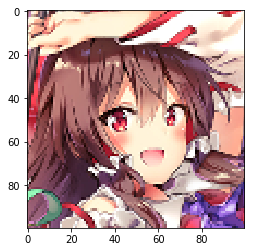

In [5]:
img_idx = random.randint(0, train_x.shape[0])
print('index:', img_idx)
plt.imshow(rescale_to_rgb(train_x[img_idx]))

**定义一些常用的函数**

定义`conv2d`, `deconv2d`, `leaky_relu`, `dense`, `batch_norm`, `calc_conv_out_shape_same`函数，与keras封装的api函数类似命名

对所有的隐藏层权重使用标准差 $\sigma=0.02$ 的正态分布（论文建议），默认对卷积层采用卷积核为 $kernel\_size=(5,5)$ ，卷积步长 $strides=(2,2)$ 进行卷积/转置卷积，batch归一化的动量改为 $momentum=0.9$，带泄露的ReLU的参数 $\alpha=0.2$

PS: 这里提供了训练期间不同batch_size的隐藏层架构，即所有数据的第一维度为None，与原代码中固定为batch_size不同，而且，源代码忽略了最后一个不完整的minibatch

feel it easy to read the following code

其实不看也没关系，大概知道干嘛就好了

In [6]:
#util functions for tensorflow neural networks
#conv2d，二维卷积层，以i为输入，输出的卷积核数为output_dim
def conv2d(i, output_dim, kernel_size = (5,5), strides = (2,2), stddev = 0.02, name = 'conv2d'):
    (k_h, k_w), (s_h, s_w) = kernel_size, strides
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_w, i.get_shape()[-1], output_dim], initializer = tf.truncated_normal_initializer(stddev = stddev))
        conv = tf.nn.conv2d(i, w, strides = [1, s_h, s_w, 1], padding = 'SAME')
        b = tf.get_variable('b', [output_dim], initializer = tf.constant_initializer(0.0))
        conv = tf.nn.bias_add(conv, b)
    return conv
#conv2d，二维转置卷积层，以i为输入，output_shape为输出，支持首个维度不定长
def deconv2d(i, output_shape, kernel_size = (5,5), strides = (2,2), stddev = 0.02, name = 'deconv2d', output_weights = False):
    (k_h, k_w), (s_h, s_w) = kernel_size, strides
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_w, output_shape[-1], i.get_shape()[-1]], initializer = tf.truncated_normal_initializer(stddev = stddev))
        if output_shape[0]:
            deconv = tf.nn.conv2d_transpose(i, w, output_shape = output_shape, strides = [1, s_h, s_w, 1])
        else:
            #增加对变化batch的反卷积支持
            deconv = tf.nn.conv2d_transpose(i, w, output_shape = [tf.shape(i)[0]] + output_shape[1:], strides = [1, s_h, s_w, 1])
            #重新确定该层的shape，否则会返回一个(?, ?, ?, ?)，而不是(?, h, w, c)
            deconv = tf.reshape(deconv, [-1] + output_shape[1:])
        b = tf.get_variable('b', [output_shape[-1]], initializer = tf.constant_initializer(0.0))
        deconv = tf.nn.bias_add(deconv, b)
    if output_weights:
        return deconv, w, b
    else:
        return deconv
#Leaky ReLU激活函数
def leaky_relu(x, alpha = 0.2, name = 'leaky_relu'):
    return tf.maximum(x, alpha * x)
#dense，全连接层，以i为输入，输出的维度为output_dim
def dense(i, output_dim, name = None, stddev = 0.02, output_weights = False):
    shape = i.get_shape().as_list()
    with tf.variable_scope(name or 'linear'):
        w = tf.get_variable('w', [shape[1], output_dim], initializer = tf.random_normal_initializer(stddev = stddev))
        b = tf.get_variable('b', [output_dim], initializer = tf.constant_initializer(0.0))
        mul = tf.matmul(i, w) + b
    if output_weights:
        return mul, w, b
    else:
        return mul
#batch归一化
def batch_norm(i, epsilon = 1e-5, momentum = 0.9, train = True, name = 'batch_norm'):
    return tf.contrib.layers.batch_norm(i, decay = momentum, updates_collections = None, epsilon = epsilon, scale = True, is_training = train, scope = name)
#用于计算padding=same时的卷积层宽高
def calc_conv_out_shape_same(size, stride):
    return int(math.ceil(float(size) / float(stride)))

**定义模型输入层**

`image_input`: 图片输入的placeholder，用于判别网络的输入

`noise_input`: 噪音输入的placeholder，用于生成网络的输入

`summary_dict`: 用于保存summary的字典，用于tensorboard的可视化

In [7]:
image_input = tf.placeholder(tf.float32, [None, image_height, image_width, channel_count], name = 'discriminator/input')
noise_input = tf.placeholder(tf.float32, [None, noise_dim], name = 'generator/input')
summary_dict = dict()

## 3. 构建你的网络
附一张论文的生成网络架构

![](./assets/g_arch.png)

注意：判别模型与生成模型要尽量相似，避免出现判别模型或生成模型过度优势的局面，如：

生成模型：我有一张齐白石的画，你能鉴别真假吗？

判别模型：切，一看就是假的，我看了这么多真画，能不知道吗

理想状态：

生成模型：我有一张齐白石的画，你能鉴别真假吗？

判别模型：哇，这个好像是真的喔

**定义判别模型**

In [8]:
def discriminator_model(input_tensor, reuse = False):
    with tf.variable_scope('discriminator') as scope:
        if reuse:
            scope.reuse_variables()

        model = conv2d(input_tensor, d_filter, name = 'layer1/conv2d')
        model = leaky_relu(model, name = 'layer1/lrelu')

        model = conv2d(model, d_filter * 2, name = 'layer2/conv2d')
        model = batch_norm(model, name = 'layer2/bn')
        model = leaky_relu(model, name = 'layer2/lrelu')

        model = conv2d(model, d_filter * 4, name = 'layer3/conv2d')
        model = batch_norm(model, name = 'layer3/bn')
        model = leaky_relu(model, name = 'layer3/lrelu')

        model = conv2d(model, d_filter * 8, name = 'layer4/conv2d')
        model = batch_norm(model, name = 'layer4/bn')
        model = leaky_relu(model, name = 'layer4/lrelu')

        model = tf.reshape(model, [tf.shape(model)[0], np.prod(model.get_shape().as_list()[1:])], name = 'layer5/flatten')
        model_logits = dense(model, 1, name = 'layer5/dense')
        model = tf.nn.sigmoid(model_logits, name = 'layer5/sigmoid')

        return model, model_logits

**定义生成模型**

In [9]:
def generator_model(input_tensor, reuse = False, train = True):
    with tf.variable_scope('generator') as scope:
        if reuse:
            scope.reuse_variables()
        
        #fc layer
        size_h = calc_conv_out_shape_same(image_height, 16)
        size_w = calc_conv_out_shape_same(image_width, 16)
        model = dense(input_tensor, size_h * size_w * g_filter * 8, name = 'layer0/fc')
        model = tf.reshape(model, [-1, size_h, size_w, g_filter * 8], name = 'layer0/reshape')
        model = batch_norm(model, name = 'layer0/bn', train = train)
        model = tf.nn.relu(model, name = 'layer0/relu')

        #deconv1
        size_h = calc_conv_out_shape_same(image_height, 8)
        size_w = calc_conv_out_shape_same(image_width, 8)
        model = deconv2d(model, [None, size_h, size_w, g_filter * 4], name = 'layer1/deconv2d')
        model = batch_norm(model, name = 'layer1/bn', train = train)
        model = tf.nn.relu(model, name = 'layer1/relu')

        #deconv2
        size_h = calc_conv_out_shape_same(image_height, 4)
        size_w = calc_conv_out_shape_same(image_width, 4)
        model = deconv2d(model, [None, size_h, size_w, g_filter * 2], name = 'layer2/deconv2d')
        model = batch_norm(model, name = 'layer2/bn', train = train)
        model = tf.nn.relu(model, name = 'layer2/relu')

        #deconv3
        size_h = calc_conv_out_shape_same(image_height, 2)
        size_w = calc_conv_out_shape_same(image_width, 2)
        model = deconv2d(model, [None, size_h, size_w, g_filter], name = 'layer3/deconv2d')
        model = batch_norm(model, name = 'layer3/bn', train = train)
        model = tf.nn.relu(model, name = 'layer3/relu')

        #deconv4(output layer)
        model = deconv2d(model, [None, image_height, image_width, channel_count], name = 'layer4/deconv2d')
        model = tf.nn.tanh(model, name = 'layer4/tanh')

        return model

**下面代码用于实例化网络**

`D`: 判别模型

`G`: 生成模型

`GAN`: 由`G`输出作为`D`输入的对抗网络模型

`Sampler`: 用于测试生成模型的效果，不改变其参数的生成模型

In [10]:
D, D_logits = discriminator_model(image_input)
G = generator_model(noise_input)
GAN, GAN_logits = discriminator_model(G, reuse = True)
Sampler = generator_model(noise_input, reuse = True, train = False)

**定义网络的loss**

定义判别器和生成器的loss，用于backprop时进行梯度下降

In [11]:
def compile_loss(D_logits, GAN_logits, summary_dict):
    #定义loss，根据sigmoid_cross_entropy_with_logits api文档，logits是未经过sigmoid函数的值
    d_loss_true = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_logits, labels = tf.ones_like(D_logits)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = GAN_logits, labels = tf.zeros_like(GAN_logits)))
    d_loss = d_loss_true + d_loss_fake
    
    summary_dict['d_loss'] = tf.summary.scalar('d_loss', d_loss) #test summary
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = GAN_logits, labels = tf.ones_like(GAN_logits)))
    
    summary_dict['g_loss'] = tf.summary.scalar('g_loss', g_loss)
    return d_loss, g_loss

**定义每个网络的相关变量和优化器**

优化器默认设置均为论文的数值

In [12]:
d_loss, g_loss = compile_loss(D_logits, GAN_logits, summary_dict)
t_vars = tf.trainable_variables()
d_vars = [var for var in t_vars if 'discriminator' in var.name]
g_vars = [var for var in t_vars if 'generator' in var.name]
d_opt = tf.train.AdamOptimizer(adam_lr, beta1 = adam_beta1).minimize(d_loss, var_list = d_vars)
g_opt = tf.train.AdamOptimizer(adam_lr, beta1 = adam_beta1).minimize(g_loss, var_list = g_vars)

In [13]:
tf.contrib.slim.model_analyzer.analyze_vars(t_vars, print_info = True)

---------
Variables: name (type shape) [size]
---------
discriminator/layer1/conv2d/w:0 (float32_ref 5x5x3x64) [4800, bytes: 19200]
discriminator/layer1/conv2d/b:0 (float32_ref 64) [64, bytes: 256]
discriminator/layer2/conv2d/w:0 (float32_ref 5x5x64x128) [204800, bytes: 819200]
discriminator/layer2/conv2d/b:0 (float32_ref 128) [128, bytes: 512]
discriminator/layer2/bn/beta:0 (float32_ref 128) [128, bytes: 512]
discriminator/layer2/bn/gamma:0 (float32_ref 128) [128, bytes: 512]
discriminator/layer3/conv2d/w:0 (float32_ref 5x5x128x256) [819200, bytes: 3276800]
discriminator/layer3/conv2d/b:0 (float32_ref 256) [256, bytes: 1024]
discriminator/layer3/bn/beta:0 (float32_ref 256) [256, bytes: 1024]
discriminator/layer3/bn/gamma:0 (float32_ref 256) [256, bytes: 1024]
discriminator/layer4/conv2d/w:0 (float32_ref 5x5x256x512) [3276800, bytes: 13107200]
discriminator/layer4/conv2d/b:0 (float32_ref 512) [512, bytes: 2048]
discriminator/layer4/bn/beta:0 (float32_ref 512) [512, bytes: 2048]
discrim

(11175300, 44701200)

**定义采样的噪音**

固定采样时的噪音，用于跟踪生成模型在每一代迭代中的变化

In [14]:
#固定随机种子
np.random.seed(0)
sample_noise = np.random.uniform(-1.0, 1.0, size = [sample_count, noise_dim])
import time
t = int(time.time())
np.random.seed(t)

In [15]:
def test_generator(sess, D, Sampler, save_file_name = None):
    noise = np.random.uniform(-1.0, 1.0, size = [1, 100])
    #noise = sample_noise
    y_pred = sess.run([Sampler], feed_dict = {noise_input: noise})[0]
    plt.figure()
    plt.imshow(rescale_to_rgb(y_pred[0]))
    plt.show()
    y_disc = sess.run([D], feed_dict = {image_input: y_pred})[0]
    print('Is True? =', y_disc[0, 0])
    if save_file_name is not None:
        io.imsave(save_file_name, rescale_to_rgb(y_pred[0]))
    return y_disc[0, 0]

In [16]:
summary_dict['d_pred'] = tf.summary.histogram('d_pred', tf.reshape(tf.concat([D, GAN], axis = 0), [1,-1]))
summary_dict['g_pred'] = tf.summary.image('g_pred', G, max_outputs = random_count)
summary_dict['g_trace'] = tf.summary.image('g_trace', G, max_outputs = sample_count * 200)

In [17]:
prev_step = 0
import re
#this code is for saving the current weights of discriminator, generator model
def save_model(sess, saver, fname, step):
    saver.save(sess, fname + '/gan', global_step = step)
    return saver

#this code is for loading the saved weights of discriminator, generator model
def load_model(sess, saver, fname):
    ckpt = tf.train.get_checkpoint_state(fname)
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
        global prev_step
        prev_step = int(re.search(re.compile('\\d+$'), ckpt.model_checkpoint_path)[0])
    return saver

In [18]:
sess = set_vram_growth()
tf.global_variables_initializer().run(session = sess)
saver = tf.train.Saver()
summary_writer = tf.summary.FileWriter('log', sess.graph)

In [19]:
saver = load_model(sess, saver, 'model')

INFO:tensorflow:Restoring parameters from model\gan-29216


In [21]:
def train_model(batch_size = 32, epoches = 20, test_generator_per_step = 100, save_weights_per_step = 500):
    m = train_x.shape[0]

    global prev_step, saver
    step_sum = prev_step
    d_loss_sum = summary_dict['d_loss']
    g_loss_sum = summary_dict['g_loss']
    
    d_pred = summary_dict['d_pred']
    g_pred = summary_dict['g_pred']
    g_trace = summary_dict['g_trace']
    for i in range(epoches):
        print('[Epoch %d of %d]' % (i, epoches))
        #随机顺序
        random_idx = np.arange(m)
        np.random.shuffle(random_idx)
        #对每个样本进行batch迭代
        steps = math.ceil(m / batch_size)
        for step in tqdm(range(steps)):
            #获取当前迭代的随机训练数据
            step_idx = random_idx[step * batch_size : (step + 1) * batch_size]
            length = len(step_idx)
            images_real = train_x[step_idx]
            noise = np.random.uniform(-1.0, 1.0, size = [length, noise_dim])
            
            _, summary, summary2 = sess.run([d_opt, d_loss_sum, d_pred], feed_dict = {image_input: images_real, noise_input: noise})
            summary_writer.add_summary(summary, step_sum)
            summary_writer.add_summary(summary2, step_sum)
            
            sess.run([g_opt], feed_dict = {noise_input: noise})
            _, summary = sess.run([g_opt, g_loss_sum], feed_dict = {noise_input: noise})
            summary_writer.add_summary(summary, step_sum)
            
            #testing G
            if (step_sum + 1) % test_generator_per_step == 0:
                noise = np.random.uniform(-1.0, 1.0, size = [random_count, noise_dim])
                summary = sess.run(g_pred, feed_dict = {noise_input: noise})
                summary_writer.add_summary(summary, step_sum + 1)
                summary = sess.run(g_trace, feed_dict = {noise_input: sample_noise})
                summary_writer.add_summary(summary, step_sum + 1)

            if (step_sum + 1) % save_weights_per_step == 0:
                saver = save_model(sess, saver, 'model', step_sum + 1)
            
            step_sum += 1
            #end step for
        #end epoch for
    saver = save_model(sess, saver, 'model', step_sum)
    prev_step = step_sum

In [22]:
train_model(batch_size = batch_size, epoches = train_epoches)

[Epoch 0 of 10]


100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [02:43<00:00,  1.86s/it]


[Epoch 1 of 10]


100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [02:52<00:00,  1.96s/it]


[Epoch 2 of 10]


100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [02:57<00:00,  2.02s/it]


[Epoch 3 of 10]


100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [03:06<00:00,  2.12s/it]


[Epoch 4 of 10]


100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [03:05<00:00,  2.11s/it]


[Epoch 5 of 10]


100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [03:04<00:00,  2.09s/it]


[Epoch 6 of 10]


100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [03:04<00:00,  2.10s/it]


[Epoch 7 of 10]


100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [03:05<00:00,  2.11s/it]


[Epoch 8 of 10]


100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [03:10<00:00,  2.16s/it]


[Epoch 9 of 10]


100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [03:06<00:00,  2.12s/it]


In [ ]:
#save_model(sess, saver, 'model', 3)

In [ ]:
#test_generator(sess, D, Sampler)

In [ ]:
#tf.reset_default_graph()

In [ ]:
summary_writer.close()